In [1]:
import sys  
sys.path.insert(0, '../scripts')
import use_data, IsInclude
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd

In [2]:
# we initialize the parameters for the geodataframe
dist = 100000
D = np.arange(25000,200001,25000,dtype=int)

filename = "simulations_reel_gdf.csv"
gdf = use_data.create_gdf(filename,'cheflieu')

In [3]:
sampleA = gdf.iloc[[1]]
id_simu_A = sampleA['id_simulation']

id_simu_tot = IsInclude.IsIn_tournee_gdf(sampleA, gdf, dist, 1)['id_simulation_right'].values
id_simu_double = IsInclude.IsIn_tournee_gdf(sampleA, gdf, dist, 2)['id_simulation_right'].values
id_simu_simple = []
for id in id_simu_tot:
    if id not in id_simu_double:
        id_simu_simple.append(id)

id_simu_B = id_simu_simple[10] # cas simple
id_simu_C = id_simu_double[4] # cas double
id_simu_D = id_simu_simple[0] # cas part

id_B = gdf.index[gdf['id_simulation']==id_simu_B][0]
id_C = gdf.index[gdf['id_simulation']==id_simu_C][0]
id_D = gdf.index[gdf['id_simulation']==id_simu_D][0]

sampleB = gdf.iloc[[id_B]] # simple inclusion
sampleC = gdf.iloc[[id_C]] # double inclusion
sampleD = gdf.iloc[[id_D]] # cas part

In [4]:
# This function will return a map and a geodataframe consisting of all mutualisables itineraires for the given sample
def exemple_inclusion(sampleA, sampleB, color):
    # Affichage du point de départ de la tournée A
    sampleA = gpd.GeoDataFrame(sampleA,geometry=sampleA['start'].map(wkt.loads))
    m = sampleA.explore(tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=4,color='black'))
    # Affichage de l'itinéraire de la tournée A
    sampleA = gpd.GeoDataFrame(sampleA,geometry=sampleA['itineraire'].map(wkt.loads))
    m = sampleA.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color='black'))
    # Affichage du cercle de rayon dist et de centre le chef-lieu de la commune de la tournée A
    geometryA = sampleA['cheflieu'].map(wkt.loads)
    sampleA = gpd.GeoDataFrame(sampleA, geometry=geometryA, crs = 'EPSG:2154') # we get the center of the cheflieu as a geometry
    sampleA['buffer'] = sampleA.geometry.buffer(dist) # create the buffer based on the cheflieu point
    sampleA = gpd.GeoDataFrame(sampleA, geometry='buffer')
    m = sampleA.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color='black'))

    # Affichage du point de départ de la tournée B
    sampleB = gpd.GeoDataFrame(sampleB,geometry=sampleB['start'].map(wkt.loads))
    m = sampleB.explore(m=m, tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=4,color=color))
    # Affichage de l'itinéraire de la tournée B
    sampleB = gpd.GeoDataFrame(sampleB,geometry=sampleB['itineraire'].map(wkt.loads))
    m = sampleB.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color=color))
    # Affichage du cercle de rayon dist et de centre le chef-lieu de la commune de la tournée B
    geometryB = sampleB['cheflieu'].map(wkt.loads)
    sampleB = gpd.GeoDataFrame(sampleB, geometry=geometryB, crs = 'EPSG:2154') # we get the center of the cheflieu as a geometry
    sampleB['buffer'] = sampleB.geometry.buffer(dist) # create the buffer based on the cheflieu point
    sampleB = gpd.GeoDataFrame(sampleB, geometry='buffer')
    m = sampleB.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color=color))

    return m

sample_map_simple = exemple_inclusion(sampleA, sampleB, 'red')
sample_map_double = exemple_inclusion(sampleA, sampleC, 'green')
sample_map_part = exemple_inclusion(sampleA, sampleD, 'orange')


In [5]:
# in black the itineraire of the chosen sample
output= "pages_html/simple_inclusion.html"
sample_map_simple.save(output)
sample_map_simple

In [6]:
output= "pages_html/double_inclusion.html"
sample_map_double.save(output)
sample_map_double

In [7]:
# in black the itineraire of the chosen sample
output= "pages_html/cas_part.html"
sample_map_part.save(output)
sample_map_part

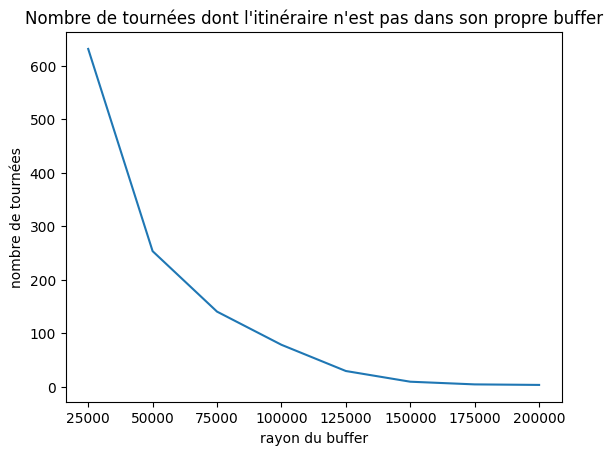

,index,variable,value
0,0,25000,631
1,0,50000,253
2,0,75000,140
3,0,100000,78
4,0,125000,29
5,0,150000,9
6,0,175000,4
7,0,200000,3


In [8]:
def sample_in_buffer(tournee, dist):
    """
    explication
    Args:
        tournee {geopandas Geodataframe line}: a row of an geodataframe
        dist {int}: buffer size in meters
    """
    geometry_buffer = tournee['cheflieu'].map(wkt.loads)
    tournee_buffer = gpd.GeoDataFrame(tournee, geometry=geometry_buffer, crs = 'EPSG:2154') # we get the center of the cheflieu as a geometry
    tournee_buffer['buffer'] = tournee_buffer.geometry.buffer(dist) # create the buffer based on the cheflieu point
    tournee_buffer = tournee_buffer.drop(columns=['ID_COM']) # drop the column to do the jointure
    tournee_buffer = gpd.GeoDataFrame(tournee_buffer, geometry='buffer') # we set the buffer as the gdf geometry

    geometry_iti = tournee['itineraire'].map(wkt.loads)
    tournee_iti = gpd.GeoDataFrame(tournee, geometry=geometry_iti, crs = 'EPSG:2154') #we set the line as a geometry

    IsIn = tournee_buffer.sjoin(tournee_iti, predicate='contains', how='inner') # we join with lines from the simulations from before the manipulation

    return IsIn.shape[0]

def sample_notIN(gdf, dist):
    nbr_notIn = 0
    n = gdf.shape[0]
    for i in range(n):
        sample = gdf.iloc[[i]]
        if sample_in_buffer(sample, dist) == 0 :
            nbr_notIn += 1
    return nbr_notIn

def graph_notIn(gdf, D):
    NBR = []
    NBR += [[sample_notIN(gdf,d) for d in D]]
    df = pd.DataFrame(NBR, columns=D)
    df['index']=df.index
    df =df.melt(id_vars='index')
    ax = sns.lineplot(data=df, x='variable', y='value')
    ax.set_title("Nombre de tournées dont l'itinéraire n'est pas dans son propre buffer")
    ax.set_xlabel("rayon du buffer")
    ax.set_ylabel("nombre de tournées")
    plt.show()
    return df


graph_notIn(gdf, D)




100%|██████████| 1097/1097 [13:13<00:00,  1.38it/s]


             25000        50000        75000       100000       125000   
count  1097.000000  1097.000000  1097.000000  1097.000000  1097.000000  \
mean      4.247949    28.461258    46.789426    68.955333   103.994531   
std       9.410962    36.230968    46.706886    55.119303    74.209127   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     2.000000     8.000000    26.000000    47.000000   
50%       0.000000     8.000000    21.000000    54.000000    88.000000   
75%       1.000000    48.000000    95.000000   129.000000   148.000000   
max      57.000000   136.000000   169.000000   226.000000   301.000000   

            150000       175000       200000        index  
count  1097.000000  1097.000000  1097.000000  1097.000000  
mean    143.024613   181.106655   220.492252   548.000000  
std      90.327932   100.279302   118.231757   316.820927  
min       0.000000     0.000000     0.000000     0.000000  
25%      75.000000   120.000000  

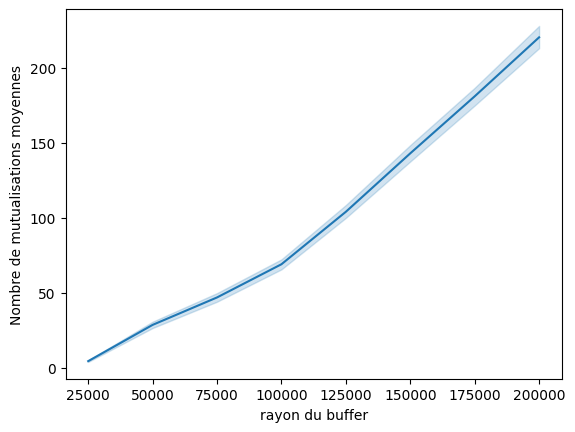

,index,variable,value
0,0,25000,1
1,1,25000,0
2,2,25000,0
3,3,25000,0
4,4,25000,0
...,...,...,...
8771,1092,200000,423
8772,1093,200000,200
8773,1094,200000,184
8774,1095,200000,184


In [10]:
def graph_Mutu(gdf, D):
    NBR = []
    for row in  tqdm(gdf.values):
        NBR += [[IsInclude.IsIn_tournee_gdf(use_data.get_itineraire(row[0],gdf),gdf,d,2).shape[0] for d in D]]
    df = pd.DataFrame(NBR, columns=D)
    df['index']=df.index
    print(df.describe())
    df =df.melt(id_vars='index')
    ax = sns.lineplot(data=df, x='variable', y='value')
    ax.set_xlabel("rayon du buffer")
    ax.set_ylabel("Nombre de mutualisations moyennes")
    plt.show()
    return df


graph_Mutu(gdf, D)